# MODELING

In [1]:
import os
import numpy as np
import pandas as pd
import typing as tp
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from catboost import CatBoostRegressor, Pool

from src import utils
from src.visualization import visualize

RS = 35

data_path = '../data/processed'
model_path = '../models'

## Baseline ridge

In [2]:
train = pd.read_pickle(os.path.join(data_path, 'train.pkl'))
target = pd.read_pickle(os.path.join(data_path, 'train_target.pkl'))

In [3]:
train_data, val_data, train_target, val_target = train_test_split(train, target, train_size=0.8, random_state=RS)

В качестве основных метрик будем использовать `r2_score` и `MSE`. В препроцессинге мы перешли к предсказанию логарифмической стоимости, поэтому в данной задаче регрессии будет удобно пользоваться этими метриками. Мы хотим получить `r2_score` как можно ближе к единице, а `MSE` как можно ближе к 0.

In [4]:
metrics = [r2_score, mean_squared_error]

def evaluate(y_true: np.ndarray, y_pred: np.ndarray, metrics: tp.List[tp.Callable] = metrics) -> None:
    print(', '.join([f'{i.__name__}={i(y_true, y_pred):.4f}' for i in metrics]))

In [5]:
kf = KFold(n_splits=5, shuffle=True, random_state=RS)
for train_index, test_index in kf.split(train):
    X_train, X_test = train.iloc[train_index], train.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    
    ridge = Ridge(random_state=RS).fit(X_train, y_train)
    
    y_pred = ridge.predict(X_test)
    
    evaluate(y_test.to_numpy(), y_pred)

r2_score=0.9160, mean_squared_error=0.0135
r2_score=0.8560, mean_squared_error=0.0228
r2_score=0.9234, mean_squared_error=0.0122
r2_score=0.7988, mean_squared_error=0.0304
r2_score=0.9023, mean_squared_error=0.0162


In [6]:
parameters = {
    'fit_intercept': [True, False],
    'alpha': [0.1, 1, 5, 10, 15, 100],
    'tol': [1e-5, 1e-3, 1e-1],
    'positive': [True, False]
}

model = Ridge(random_state=RS, max_iter=1000)
clf = GridSearchCV(model, parameters, scoring='r2', cv=3)
clf.fit(train_data, train_target)
clf.best_params_

{'alpha': 10, 'fit_intercept': True, 'positive': True, 'tol': 0.001}

In [7]:
ridge = Ridge(random_state=RS, max_iter=1000, **clf.best_params_).fit(train_data, train_target)
y_pred = ridge.predict(val_data)
evaluate(val_target.to_numpy(), y_pred)

r2_score=0.9225, mean_squared_error=0.0125


In [8]:
utils.save_model(ridge, os.path.join(model_path, 'ridge.pkl'))

## Catboost

In [9]:
pool = Pool(train_data, train_target, )

cb = CatBoostRegressor(iterations=2000, loss_function='RMSE', eval_metric='RMSE', learning_rate=0.03, silent=True)

cb.fit(pool, eval_set=(val_data, val_target), verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [10]:
y_pred = cb.predict(val_data)
evaluate(val_target.to_numpy(), y_pred)

r2_score=0.9189, mean_squared_error=0.0130


In [11]:
utils.save_model(cb, os.path.join(model_path, 'catboost.pkl'))

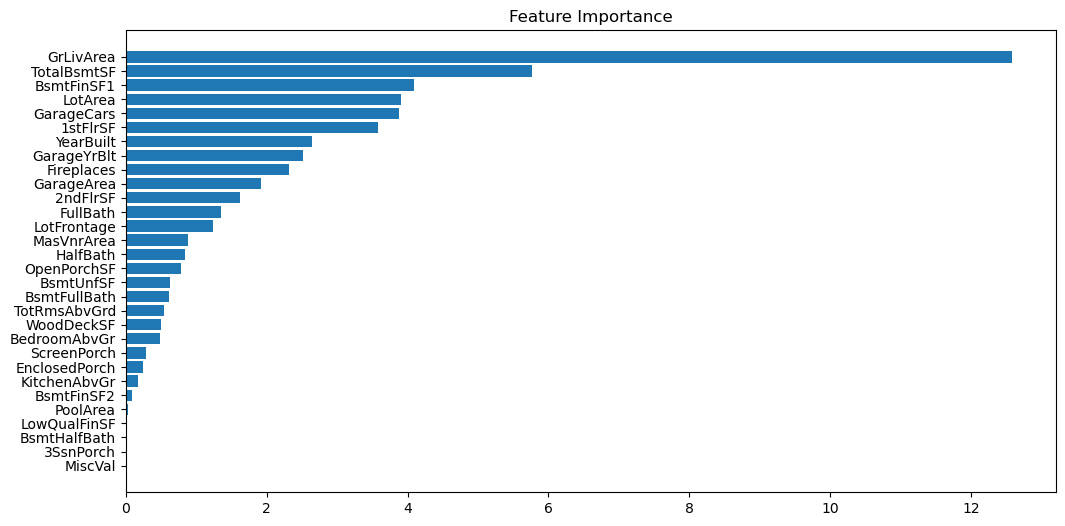

In [12]:
feature_importance = cb.feature_importances_[:30]
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

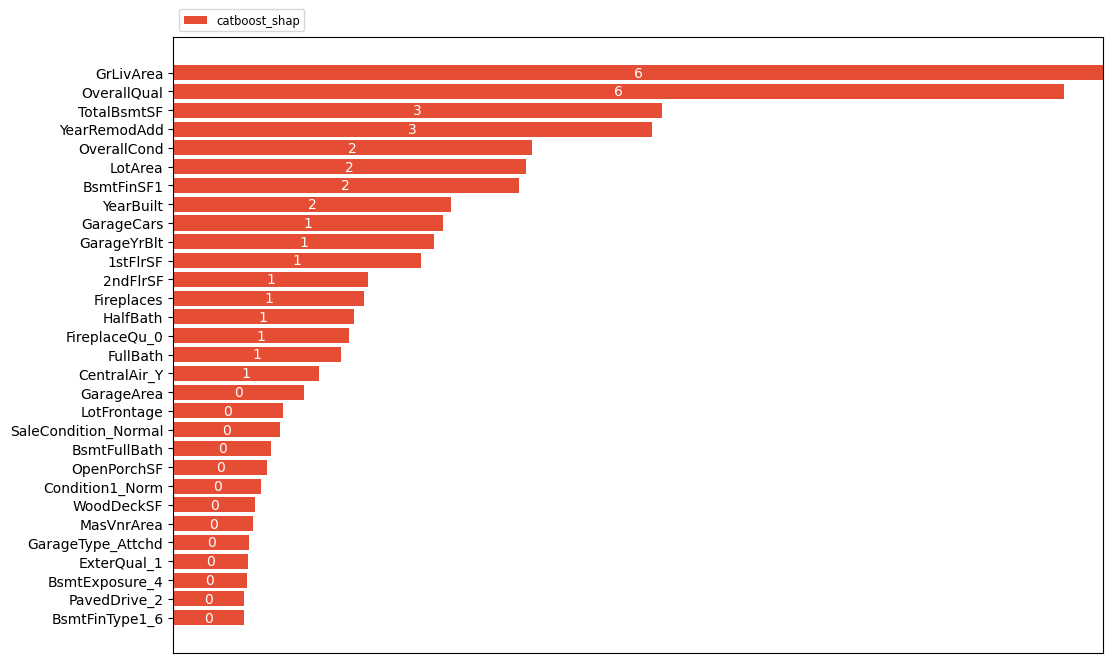

In [13]:
import shap

explainer = shap.Explainer(cb)
shap_values = explainer(train_data)
shap_importance = shap_values.abs.mean(0).values
results = {i: 100 * j for i, j in zip(train_data.columns, shap_importance)}
results_sorted = {k: [results[k]] for k in np.take_along_axis(np.array(list(results.keys())), np.argsort(np.array(list(results.values()))), 0)[::-1]}
results = {}
for i, k in enumerate(results_sorted):
    if i >= 30:
        break
    results[k] = results_sorted[k]

visualize.survey(results, ['catboost_shap'])
plt.savefig("../reports/figures/feature_importance.png")